In [801]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt

In [802]:
# TO DO
# need to figure out how to ger around ema_a > ema_b on second time while rsi check is positive.
# dkng u path nvda arkg pltr ttd sofi ionq tsla googl celh arm rblx hcp ai joby

In [803]:
ticker = 'nvda'

In [804]:
# Fetch data for a ticker
df = yf.download(ticker, start='2023-01-01', end='2024-09-27')

[*********************100%%**********************]  1 of 1 completed


In [805]:
df.head(1)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-03,14.851,14.996,14.096,14.315,14.305581,401277000


In [806]:
# Calculate moving averages 5|7 3|21 5|13
df['EMA_A'] = df['Close'].ewm(span=5, adjust=False).mean()
df['EMA_B'] = df['Close'].ewm(span=7, adjust=False).mean()

In [807]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,EMA_A,EMA_B
Date,,,,,,,,
2023-01-03,14.851,14.996,14.096,14.315,14.305581,401277000,14.315000,14.315000
2023-01-04,14.567,14.853,14.241,14.749,14.739295,431324000,14.459666,14.423500
2023-01-05,14.491,14.564,14.148,14.265,14.255614,389168000,14.394778,14.383875
2023-01-06,14.474,15.010,14.034,14.859,14.849224,405044000,14.549518,14.502656
2023-01-09,15.284,16.056,15.141,15.628,15.617718,504231000,14.909012,14.783992


In [808]:
# Calculate the RSI
delta = df['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
rsi = 100 - (100 / (1 + rs))

# Define the overbought and oversold levels (typically 70 and 30, respectively)
overbought_level = float(80.0)
oversold_level = float(30.0)

# Compute the median between overbought and oversold levels
median_rsi = np.median([overbought_level, oversold_level])

# Add the Median_RSI column indicating whether RSI is above or below the median
df['Median_RSI'] = np.where(rsi > median_rsi, 'above_median', 'below_median')

# add rsi column with rsi value
df['rsi'] = rsi

# ensure rsi is above median to be used in the crossed_above condition
rsi_check = df['rsi'] > median_rsi

In [809]:
# Calculate MACD and signal line
def calculate_macd(df):
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd, signal

df['MACD'], df['Signal'] = calculate_macd(df)

In [810]:
# Identify when the 5-day EMA crosses above the 21-day EMA & rsi_check condition is met
crossed_above = (df['EMA_A'] > df['EMA_B']) & (df['EMA_A'].shift(1) < df['EMA_B'].shift(1)) & (rsi_check) 

# Identify when the 5-day EMA crosses above the 21-day EMA
# crossed_above = (df['EMA_A'] > df['EMA_B']) & (df['EMA_A'].shift(1) < df['EMA_B'].shift(1)) 

In [811]:
# # # Identify when the MACD line crosses below the signal line
# crossed_above = (df['MACD'] > df['Signal']) & (df['MACD'].shift(1) <= df['Signal'].shift(1))

In [812]:
df.loc[crossed_above, 'Cross_Direction'] = 'crossed up'

In [813]:
# Identify when the A-day EMA crosses below the B-Day EMA
crossed_below = (df['EMA_A'] < df['EMA_B']) & (df['EMA_A'].shift(1) > df['EMA_B'].shift(1))

df.loc[crossed_below, 'Cross_Direction'] = 'crossed down'

In [814]:
# # Identify when the A-day EMA crosses below the B-Day EMA
# crossed_below_ema = (df['EMA_A'] < df['EMA_B']) & (df['EMA_A'].shift(1) > df['EMA_B'].shift(1))

# # Identify when the MACD line crosses below the signal line
# crossed_below_macd = (df['MACD'] < df['Signal']) & (df['MACD'].shift(1) > df['Signal'].shift(1))

# # Combine both conditions using logical OR operator
# crossed_below = crossed_below_ema | crossed_below_macd

# # Update the 'Cross_Direction' column
# df.loc[crossed_below, 'Cross_Direction'] = 'crossed down'

In [815]:
# # Identify when the MACD line crosses below the signal line
# crossed_below = (df['MACD'] < df['Signal']) & (df['MACD'].shift(1) > df['Signal'].shift(1))

# # Update the 'Cross_Direction' column
# df.loc[crossed_below, 'Cross_Direction'] = 'crossed down'

In [816]:
# Filter for rows where the 5-day EMA crossed either above or below the 21-day EMA
condition_met = df[df['Cross_Direction'].notna()]

In [817]:
# Display the dates when the conditions were met and the direction of the crossover
print("\nDates when the conditions were met and cross direction:")
condition_met[['Close', 'EMA_A', 'EMA_B', 'Cross_Direction', 'Median_RSI', 'rsi']]


Dates when the conditions were met and cross direction:


,Close,EMA_A,EMA_B,Cross_Direction,Median_RSI,rsi
Date,,,,,,
2023-02-21,20.655001,21.515182,21.600527,crossed down,above_median,56.119992
2023-02-23,23.664000,22.062303,21.957671,crossed up,above_median,59.803431
2023-03-13,22.966000,23.232291,23.250087,crossed down,above_median,63.906607
2023-03-14,24.063000,23.509194,23.453315,crossed up,above_median,67.776947
2023-04-12,26.495001,27.009484,27.046070,crossed down,below_median,50.227852
2023-04-18,27.667000,27.135762,27.091034,crossed up,above_median,61.110126
2023-04-25,26.240999,26.863413,26.941074,crossed down,below_median,39.128095
2023-06-28,41.117001,41.650595,41.709168,crossed down,above_median,64.926237
2023-07-03,42.412998,41.926730,41.871523,crossed up,above_median,62.132623


In [818]:
df

,Open,High,Low,Close,Adj Close,Volume,EMA_A,EMA_B,Median_RSI,rsi,MACD,Signal,Cross_Direction
Date,,,,,,,,,,,,,
2023-01-03,14.851000,14.996000,14.096000,14.315000,14.305581,401277000,14.315000,14.315000,below_median,NaN,0.000000,0.000000,NaN
2023-01-04,14.567000,14.853000,14.241000,14.749000,14.739295,431324000,14.459666,14.423500,below_median,NaN,0.034621,0.006924,NaN
2023-01-05,14.491000,14.564000,14.148000,14.265000,14.255614,389168000,14.394778,14.383875,below_median,NaN,0.022742,0.010088,NaN
2023-01-06,14.474000,15.010000,14.034000,14.859000,14.849224,405044000,14.549518,14.502656,below_median,NaN,0.060560,0.020182,NaN
2023-01-09,15.284000,16.056000,15.141000,15.628000,15.617718,504231000,14.909012,14.783992,below_median,NaN,0.150844,0.046315,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-20,117.059998,118.620003,115.389999,116.000000,116.000000,382462400,115.969427,115.693625,below_median,46.414128,-0.413649,-0.790791,NaN
2024-09-23,116.550003,116.989998,114.860001,116.260002,116.260002,206228500,116.066285,115.835219,above_median,61.510595,-0.316587,-0.695950,NaN
2024-09-24,116.519997,121.800003,115.379997,120.870003,120.870003,354966800,117.667524,117.093915,above_median,68.940575,0.130817,-0.530597,NaN


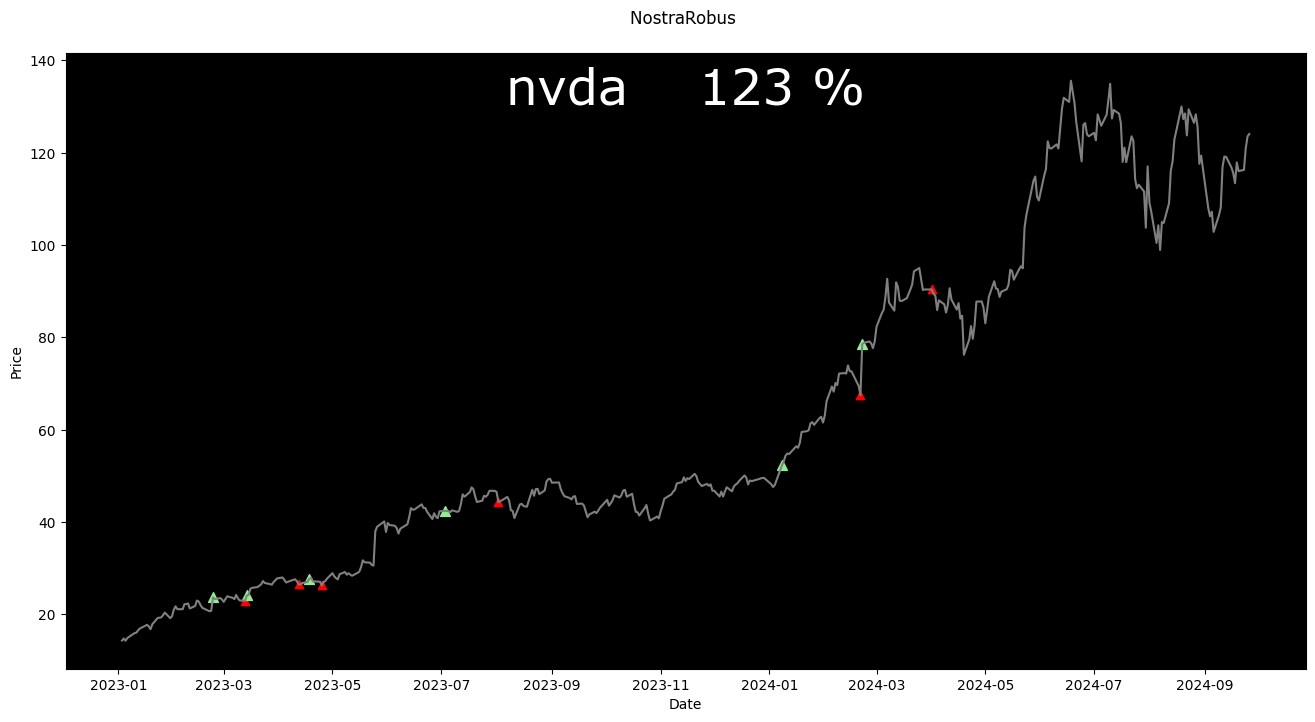

Results For Ticker:   nvda
Initial Investment:  23.663999557495117
Final Portfolio Value:  52
Profit/Loss:  29.2
Percent: 123.4%




,Action,Date,Open,Close,Price,Cash
0,Buy,2023-02-23,23.440001,23.664000,23.664000,0.000000
1,Sell,2023-03-13,22.752001,22.966000,22.752001,22.966000
2,Buy,2023-03-14,23.496000,24.063000,24.063000,-1.097000
3,Sell,2023-04-12,27.370001,26.495001,27.370001,25.398001
4,Buy,2023-04-18,27.533001,27.667000,27.667000,-2.268999
5,Sell,2023-04-25,27.077999,26.240999,27.077999,23.972000
6,Buy,2023-07-03,42.516998,42.412998,42.412998,-18.440998
7,Sell,2023-08-02,45.831001,44.269001,45.831001,25.828003
8,Buy,2024-01-08,49.512001,52.252998,52.252998,-26.424995
9,Sell,2024-02-21,68.005997,67.472000,68.005997,41.047005


In [819]:
# Initialize variables
init_cost = 1 # we need this set so when conditions are not met, we don't divide by 0
cash = init_cost  # Initial cash balance
shares_owned = 0
portfolio_value = cash
prev_crossed_above = False
rsi_above_median = False
transactions = []
last_trans = 'crossed down'
df.iloc[-1, df.columns.get_loc('Cross_Direction')] = last_trans

# Plot the line graph with arrows indicating the direction of crossover
plt.figure(figsize=(16, 8))
plt.plot(df.index, df['Close'], label='Close Price', color='gray')
plt.gca().set_facecolor('black')  # Set the background color to black



# Find the first crossed up event and set the initial cost
for index, row in df.iterrows():
    if row['Cross_Direction'] == 'crossed up':
        init_cost = row['Close']  # Set init_cost to the price at the first crossed up event
        cash = init_cost  # Set cash to the initial cost
        break

# Loop through the dataframe
for index, row in df.iterrows():
    if row['Cross_Direction'] == 'crossed up' and prev_crossed_above == False:  # Check if the Cross_Direction column is 'crossed up'
        # Buy one share
        # shares_owned += 1
        cash -= row['Close']  # Deduct purchase price from cash
        transactions.append(('Buy', index, row['Open'], row['Close'], row['Close'], cash))
        prev_crossed_above = True
        plt.scatter(index, row['Close'], marker='^', color='lightgreen', s=50, label='Crossed Up')
    elif row['Cross_Direction'] == 'crossed down' and prev_crossed_above:  # Check if the Cross_Direction column is 'crossed down':
        cash += row['Close'] #* shares_owned  # Add sale price to cash
        transactions.append(('Sell', index, row['Open'], row['Close'], row['Open'], cash))
        prev_crossed_above = False
        plt.scatter(index, row['Close'], marker='^', color='red', label='Crossed Down')
    else:
        pass
    
# Calculate final portfolio value
portfolio_value = cash

# Evaluate performance
initial_investment = init_cost # Initial cash investment
profit_loss = portfolio_value - initial_investment

percent = (profit_loss / initial_investment) * 100

# Add the ticker symbol and other things as labels
plt.text(0.5, 0.9, ticker + '    ' + str(round(percent)) + ' %', transform=plt.gca().transAxes, fontsize=36, verticalalignment='bottom', \
         horizontalalignment='center', fontname='MS Reference Sans Serif', fontweight='bold', color='white')
plt.title('NostraRobus \n', fontname='MS Reference Sans Serif', fontweight='bold', color='black')
plt.xlabel('Date', color='black')
plt.ylabel('Price', color='black')
plt.tick_params(axis='x', colors='black')
plt.tick_params(axis='y', colors='black')
plt.grid(False)
plt.show()



print('Results For Ticker:  ', ticker)
print('Initial Investment: ', initial_investment)
print("Final Portfolio Value: ", int(portfolio_value))
print("Profit/Loss: ", round(profit_loss,1))
print("Percent: {:.1f}%".format(percent))
print('\n')
transactions_df = pd.DataFrame(transactions, columns=['Action', 'Date', 'Open', 'Close', 'Price', 'Cash'])
transactions_df



In [823]:
# df.to_csv(r'C:\Users\rindel\Downloads\filename.csv', index=True)
# transactions_df.to_csv('filename.csv', index=True)
